# Centroids-and-Scatterplot.ipynb

In [1]:
#!/usr/bin/env python
'''File name: Centroids-and-Scatterplot.py
    Author: Andreas Prein
    E-mail: prein@ucar.edu
    Date created: 16.04.2018
    Date last modified: 16.04.2018

    ############################################################## 
    Purpos:

    Apply the optimal settings for the region of interest that was
    determined with:
    ~/papers/Extreme-WTs-US/programs/Extreme-WTs/SearchOptimum_ExtremeEvent-WeatherTyping.py

    1) Read the PRISM and ERA-Interim data
    2) Calculate the WT centroids
    3) Plot the Centroids
    3) Calculate Eucledian Distances for each day
    4) Plot ED vs. PR accumulation

'''

from dateutil import rrule
import datetime
import glob
from netCDF4 import Dataset
import sys, traceback
import dateutil.parser as dparser
import string
from pdb import set_trace as stop
import numpy as np
import numpy.ma as ma
import os
from mpl_toolkits import basemap
# import ESMF
import pickle
import subprocess
import pandas as pd
from scipy import stats
import copy
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib as mpl
import pylab as plt
import random
import scipy.ndimage as ndimage
import scipy
import shapefile
import matplotlib.path as mplPath
from matplotlib.patches import Polygon as Polygon2
# Cluster specific modules
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.vq import kmeans2,vq, whiten
from scipy.ndimage import gaussian_filter
import seaborn as sns
# import metpy.calc as mpcalc
import shapefile as shp
import sys
import matplotlib.gridspec as gridspec
from mpl_toolkits.basemap import Basemap, cm
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.gridspec as gridspec
# from pylab import *
import string
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import shapefile

from Functions_Extreme_WTs import XWT
from Functions_Extreme_WTs import MRR, MRD, perkins_skill
from Functions_Extreme_WTs import PreprocessWTdata
from Functions_Extreme_WTs import Centroids_to_NetCDF

# mpl.use('Agg')

def read_shapefile(sf):
    """
    Read a shapefile into a Pandas dataframe with a 'coords' 
    column holding the geometry information. This uses the pyshp
    package
    """
    fields = [x[0] for x in sf.fields][1:]
    records = sf.records()
    shps = [s.points for s in sf.shapes()]
    df = pd.DataFrame(columns=fields, data=records)
    df = df.assign(coords=shps)
    return df

In [4]:
# ###################################################
# Get the setup for the XWTing
Season='JJASOND' # ['AMJJAS', 'ONDJFM']
iReg= '15' #str("%02d" % int(sys.argv[1])) # str("%02d" % int(1)) #str("%02d" % int(sys.argv[1]))
Region=iReg+'/WBDHU2' # ['01/WBDHU2']


from HUC2_XWTs_apply_PL_FLX_combination import HUC2_XWTs_apply
rgdTime, iMonths, sPlotDir, Region, sDataDir, sSubregionPR, rgsWTvars, VarsFullName,rgsWTfolders, rgrNrOfExtremes, WT_Domains, \
DomDegreeAdd, Annual_Cycle, SpatialSmoothing, Metrics, Dimensions, ClusterMeth, ClusterBreakup, RelAnnom, NormalizeData, \
MinDistDD, RemoveAnnualCycl = HUC2_XWTs_apply(Season,Region)

# rgrNrOfExtremes=int(rgrNrOfExtremes*2)  # since split sample is done on half record
rgrNrOfExtremes=rgrNrOfExtremes
sSubregionPR=sSubregionPR+Region
# create nessesary directories
if not os.path.exists(sDataDir):
    os.makedirs(sDataDir)
if not os.path.exists(sPlotDir):
    os.makedirs(sPlotDir)
sRegion=Region.replace('/','-')

YYYY_stamp=str(rgdTime.year[0])+'-'+str(rgdTime.year[-1])
ss='-'
VarsJoint=ss.join(VarsFullName)
sMonths=ss.join([str(iMonths[ii]) for ii in range(len(iMonths))])
rgiSeasonWT=np.isin(rgdTime.month, iMonths)
rgiYears=np.unique(rgdTime.year)
rgdTime=rgdTime[rgiSeasonWT]
SPLIT=np.where(rgdTime.year <= rgiYears[int(len(rgiYears)/2)])[0][-1]


sPlotDir=sPlotDir+sRegion+'/'
if not os.path.exists(sPlotDir):
    os.makedirs(sPlotDir)

print( str(rgrNrOfExtremes)+' EXTREMES')
iNrOfExtremes=rgrNrOfExtremes   # we consider the N highest rainfall extremes


# ###################################################
#       READ IN SHAPEFILE
ncid=Dataset('/glade/campaign/mmm/c3we/prein/observations/PRISM/data/PR/PRISM_daily_ppt_2014.nc', mode='r') # open the netcdf file
rgrLatPR=np.squeeze(ncid.variables['lat'][:])
rgrLonPR=np.squeeze(ncid.variables['lon'][:])
ncid.close()
rgrGridCells=[(rgrLonPR.ravel()[ii],rgrLatPR.ravel()[ii]) for ii in range(len(rgrLonPR.ravel()))]
rgrSRactP=np.zeros((rgrLonPR.shape[0]*rgrLonPR.shape[1]))
sf = shp.Reader(sSubregionPR)
df = read_shapefile(sf)
for sf in range(df.shape[0]):
    ctr = df['coords'][sf]
    if len(ctr) > 10000:
        ctr=np.array(ctr)[::100,:] # carsen the shapefile accuracy
    else:
        ctr=np.array(ctr)
    grPRregion=mplPath.Path(ctr)
    TMP=np.array(grPRregion.contains_points(rgrGridCells))
    rgrSRactP[TMP == 1]=1
rgrSRactP=np.reshape(rgrSRactP, (rgrLatPR.shape[0], rgrLatPR.shape[1]))

DomainSizes=['S','M','L','XXL']
DomDegreeAdd=[2,5,10,20]
DomDelta=DomDegreeAdd[DomainSizes.index(WT_Domains)]

Wlon=ctr[:,0].min()
Elon=ctr[:,0].max()
Nlat=ctr[:,1].max()
Slat=ctr[:,1].min()
DomainWT=np.array([[Elon+DomDelta,Slat-DomDelta],
                   [Wlon-DomDelta,Slat-DomDelta],
                   [Wlon-DomDelta,Nlat+DomDelta],
                   [Elon+DomDelta,Nlat+DomDelta],
                   [Elon+DomDelta,Slat-DomDelta]])
grWTregion=mplPath.Path(DomainWT)

# ###################################################
#         Read the PRISM grid and data
sPRsave=sDataDir+'Precipitation-Records_'+str(iNrOfExtremes)+'_'+sRegion+'_'+YYYY_stamp+'_'+sMonths
if os.path.isfile(sPRsave+'.npz')  == 0:
    from Functions_Extreme_WTs import ReadPRISM
    rgrPRrecords, rgiExtremePR, PR_Full = ReadPRISM(rgiYears,        # array containing the years that should be read
                                           iNrOfExtremes,   # number of extreme events
                                           rgiSeasonWT,     # months that should be processed
                                           iMonths,         # array of months that should be read in
                                           grPRregion)      # shapefile that contains target region

    np.savez(sPRsave, rgrPRrecords=rgrPRrecords, rgiExtremePR=rgiExtremePR,PR_Full=PR_Full)
else:
    print( '    Restore: '+sPRsave+'.npz')
    npzfile = np.load(sPRsave+'.npz')
    rgrPRrecords=npzfile['rgrPRrecords']
    rgiExtremePR=npzfile['rgiExtremePR']
    PR_Full=npzfile['PR_Full']

rgiExtremeDays=rgdTime[rgiExtremePR]

# ###################################################
# ###################################################
#             PERFORM CLUSTER ANALYSIS

# ###################################################
#         Read the ERA-Interim grid and data

from Functions_Extreme_WTs import ReadERAI
DailyVarsOrig, LonWT, LatWT=ReadERAI(grWTregion,        # shapefile with WTing region
                                     rgdTime,           # time period for WTing
                                     iMonths,           # list of months that should be considered
                                     rgsWTfolders,      # directories containing WT files
                                     rgsWTvars)         # netcdf variable names of WT variables
# run split sample thest and derive centroids of full dataset
Samples=['SS1',"SS2","Full"]
grClustersFin={}
grEucledianDist={}
grCorrelation={}
grPSS={}
grMRD={}
grMRR={}
grExluded={}
grAPR={}
grAUC={}

DailyVarsTrain=DailyVarsOrig
DailyVarsEval=DailyVarsOrig
Ptrain=rgrPRrecords
Peval=rgrPRrecords
TimeTrain=rgdTime
TimeEval=rgdTime
if iNrOfExtremes > len(TimeEval):
    iExtrNr = len(TimeEval)
else:
    iExtrNr = iNrOfExtremes        

        

99999 EXTREMES
    Restore: /glade/campaign/mmm/c3we/prein/Projects/Arizona_WTing/data/hdbscan/Precipitation-Records_99999_15-WBDHU2_2010-2018_6-7-8-9-10-11-12.npz
        Read ERA-I year: 2010
        Read ERA-I year: 2011
        Read ERA-I year: 2012
        Read ERA-I year: 2013
        Read ERA-I year: 2014
        Read ERA-I year: 2015
        Read ERA-I year: 2016
        Read ERA-I year: 2017
        Read ERA-I year: 2018


In [6]:
DailyVars=DailyVarsOrig #-Averaged[:,None,None,:]

# calculate relative anomalies??
DailyVars=(DailyVars-np.mean(DailyVars, axis=0)[None,:])/np.mean(DailyVars, axis=0)[None,:]

# Spatially smooth the data
DailyVars=gaussian_filter(DailyVars[:,:,:,:], sigma=(0,SpatialSmoothing,SpatialSmoothing,0))

# # remove annual cycle
# SpatialMeanData=pd.DataFrame(np.nanmean(DailyVarsOrig, axis=(1,2)))
# Averaged=np.roll(np.array(SpatialMeanData.rolling(window=21).mean()), -10, axis=0)
# Averaged[:10,:]=Averaged[11,:][None,:]; Averaged[-10:,:]=Averaged[-11,:][None,:]

        
        
# normalize the data
DailyVars = (DailyVars-np.mean(DailyVars, axis=(0,1,2))[None,None,None,:])/np.std(DailyVars, axis=(0,1,2))[None,None,None,:]

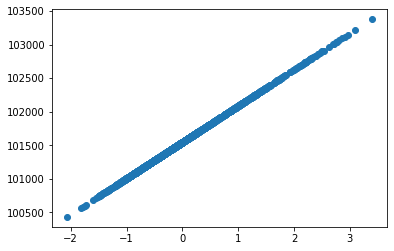

In [7]:
plt.scatter(np.mean(DailyVars[:,:,:,0], axis=(1,2)), np.mean(DailyVarsOrig[:,:,:,0], axis=(1,2))); plt.show()

In [8]:
rgsWTvars

array(['var151'], dtype='<U6')

In [9]:
# do the clustering
rgrWTdata = np.copy(DailyVars)
rgrDataCluster=np.reshape(rgrWTdata, (rgrWTdata.shape[0],rgrWTdata.shape[1]*rgrWTdata.shape[2]*rgrWTdata.shape[3]))
rgrCluster = linkage(rgrDataCluster, 'ward')
cc, coph_dists = cophenet(rgrCluster, pdist(rgrDataCluster))

# last = rgrCluster[-25:, 2]
last = rgrCluster[-6:, 2]
last_rev = last[::-1]
idxs = np.arange(1, len(last) + 1)

acceleration = np.diff(last, 2)  # 2nd derivative of the distances
acceleration_rev = acceleration[::-1]
iClusters1=0
try:
    while acceleration_rev[iClusters1] > 0: iClusters1=iClusters1+1
    iClusters2=np.where(max(acceleration_rev) == acceleration_rev)[0][0]+1
except:
    iClusters2=iClusters1
iClusters=np.max([iClusters1,iClusters2])+1
rThreshold=last[-iClusters]

rgiClusterMembers=fcluster(rgrCluster,rThreshold, criterion='distance')
rgrClusters=np.zeros((rgiClusterMembers.max(),rgrDataCluster.shape[1])); rgrClusters[:]=np.nan
for cc in range(rgiClusterMembers.max()):
    rgiClAct=(rgiClusterMembers == (cc+1))
    rgrClusters[cc,:]=np.mean(rgrDataCluster[rgiClAct,:], axis=0)

# use this as initial seed for the k-means clustering
rgrClustersFin=kmeans2(rgrDataCluster,rgrClusters)


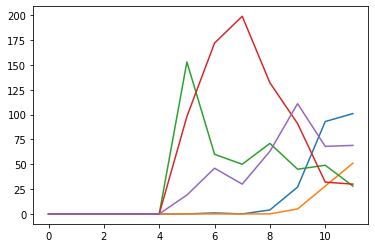

In [10]:
# WT histograms
WTnr = rgrClustersFin[1].max()
MonthlyWTfreq = np.zeros((12,WTnr+1))
for wt in range(WTnr+1):
    TimeTMP = rgdTime[rgrClustersFin[1] == wt]
    for mo in range(12):
        MonthlyWTfreq[mo,wt] = np.sum(TimeTMP.month == (mo+1))
        
plt.plot(MonthlyWTfreq)

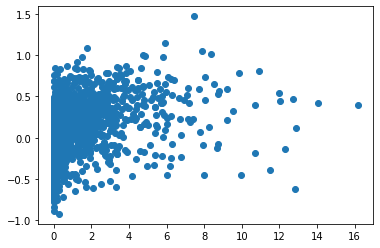

In [9]:
plt.scatter(rgrPRrecords,np.mean(DailyVars, axis=(1,2,3)))

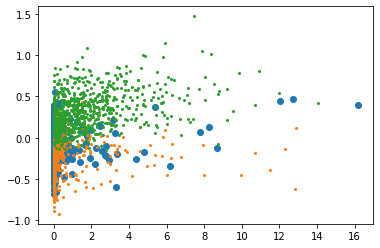

In [10]:
plt.scatter(rgrPRrecords[rgrClustersFin[1]==0],np.mean(DailyVars, axis=(1,2,3))[rgrClustersFin[1]==0])
plt.scatter(rgrPRrecords[rgrClustersFin[1]==1],np.mean(DailyVars, axis=(1,2,3))[rgrClustersFin[1]==1], s=4)
plt.scatter(rgrPRrecords[rgrClustersFin[1]==2],np.mean(DailyVars, axis=(1,2,3))[rgrClustersFin[1]==2], s=4)
plt.scatter(rgrPRrecords[rgrClustersFin[1]==3],np.mean(DailyVars, axis=(1,2,3))[rgrClustersFin[1]==3], s=4)

        Plot map to: BottomUp-Hirarch-Cluster_Dendrogram_1926_2010-2010.pdf
        Plot map to: Accelaration-Of-Distance-Growth_1926_2010-2010.pdf
    save: /glade/campaign/mmm/c3we/prein/Projects/Arizona_WTing/data/hdbscan/15-WBDHU2_XWT-centroids_train-2010-2018_eval-2010-2018_E99999_XWTs3_Vars-PW-PSL-MFL850_M-6-7-8-9-10-11-12.nc
    plot: /glade/u/home/prein/projects/Arizona_WTing/plots/WT-Centroids15-WBDHU2/Scatter_15-WBDHU2_NrExt-99999_Smooth-0.5_AnnCy-1_PW-PSL-MFL850_6-7-8-9-10-11-12_Full.pdf


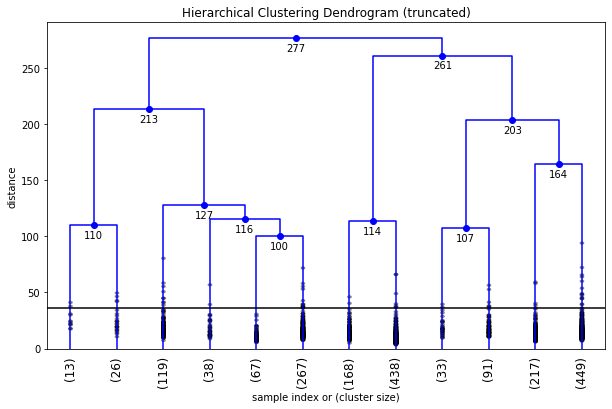

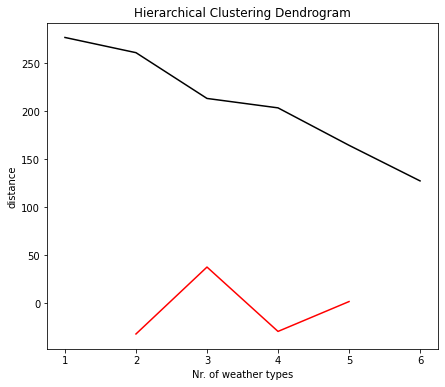

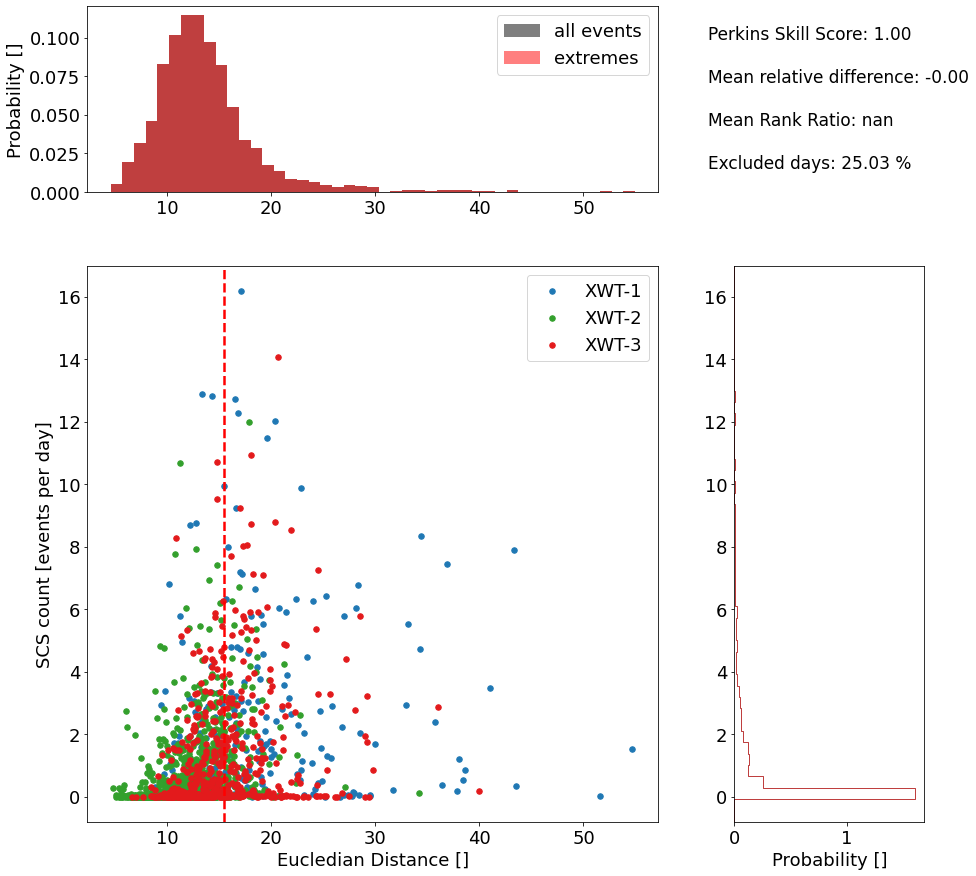

In [11]:
ss=2
        
XWT_output=XWT(DailyVarsTrain,
    DailyVarsEval,
    Ptrain,
    Peval,
    TimeTrain,
    TimeEval,
    iExtrNr,
    SpatialSmoothing,
    ClusterMeth=ClusterMeth,
    ClusterBreakup=ClusterBreakup,
    RelAnnom=RelAnnom)


# ################################################
# ######       EUCLEDIAN DISTANCES
EucledianDist=XWT_output['EucledianDistAllWTs']
Correlation =XWT_output['grCorrelatioAllWTs']
rgrClustersFin=XWT_output['grClustersFin']

NetCDFname=sDataDir+sRegion+'_XWT-centroids_train-'+str(TimeTrain.year[0])+'-'+str(TimeTrain.year[-1])+\
    '_eval-'+str(TimeEval.year[0])+'-'+str(TimeEval.year[-1])+'_E'+str("%03d" % iNrOfExtremes)+\
    '_XWTs'+str(rgrClustersFin[1].max()+1)+'_Vars-'+VarsJoint+'_M-'+sMonths+'.nc'
print('    save: '+NetCDFname)
Centroids_to_NetCDF(NetCDFname,
                XWT_output,
                LonWT,
                LatWT,
                DailyVarsTrain,
                rgdTime,
                TimeEval,
                VarsJoint,
                rgiExtremeDays)

from Functions_Extreme_WTs import Scatter_ED_PR
MinDistance=np.min(EucledianDist, axis=1)
ClosestWT=np.argmin(EucledianDist, axis=1)
MaxCorr=np.max(Correlation, axis=1)
Scatter_ED_PR(MinDistance,
              ClosestWT,
              Peval,
              rgrNrOfExtremes,
              PlotLoc=sPlotDir,
              PlotName='Scatter_'+sRegion+'_NrExt-'+str(rgrNrOfExtremes)+'_Smooth-'+str(SpatialSmoothing)+'_AnnCy-'+Annual_Cycle+'_'+VarsJoint+'_'+sMonths+'_'+Samples[ss]+'.pdf')

# Perkins Skill Score
grPSS[Samples[ss]]=XWT_output['grPSS']
# Mean relative difference
grMRD[Samples[ss]]=XWT_output['grMRD']
# Mean Rank Ratio
grMRR[Samples[ss]]=XWT_output['grMRR']
# % of days excluded
grExluded[Samples[ss]]=XWT_output['PEX']
# % of days excluded
grAPR[Samples[ss]]=XWT_output['APR']
# % of days excluded
grAUC[Samples[ss]]=XWT_output['AUC']             

# save the data
grClustersFin[Samples[ss]]=XWT_output['grClustersFin']
grEucledianDist[Samples[ss]]=XWT_output['grEucledianDist']
grCorrelation[Samples[ss]]=XWT_output['grCorrelatio']

DATAcollection={'grClustersFin':grClustersFin, 
            'grEucledianDist': grEucledianDist, 
            'grCorrelatio':grCorrelation,
            'grPSS':grPSS,
            'grMRD':grMRD,
            'grMRR':grMRR,
            'grExluded':grExluded,
            'grAPR':grAPR,
            'grAUC':grAUC,
            'LonWT':LonWT,
            'LatWT':LatWT,
            'iReg':iReg,
            'VarsFullName':VarsFullName,
            'rgrNrOfExtremes':rgrNrOfExtremes,
            'WT_Domains':WT_Domains,
            'SpatialSmoothing':SpatialSmoothing,
            'MinDistance':MinDistance,
            'Peval':Peval,
            'rgdTime':rgdTime}

# with open(sClusterSave, 'wb') as handle:
# pickle.dump(DATAcollection, handle)
# else:
#     print( '    Restore: '+sClusterSave)
# with open(sClusterSave, 'rb') as handle:
#     npzfile = pickle.load(handle)

# grClustersFin=npzfile['grClustersFin']
# grEucledianDist=npzfile['grEucledianDist']
# grCorrelation=npzfile['grCorrelatio']

rgrClustersFin=grClustersFin['Full']
EucledianDist=grEucledianDist['Full']
Correlation=grCorrelation['Full']

# sort the clusters according to the number of days to ensure that the
# same pattern is at the same location for different event sample sizes
rgiClustSize=[sum(rgrClustersFin[1] == cc) for cc in range(rgrClustersFin[1].max()+1)]
rgiSorted=np.argsort(rgiClustSize)
rgiSorted=range(len(rgiSorted))

### Plot the synoptic setup and the centroids

In [12]:
from Functions_Extreme_WTs import add_subplot_axes

rgsWTvarsA=['z','u','v','IVT']
rgsWTfoldersA=['/glade/campaign/mmm/c3we/prein/ERA-Interim/Z500/Z500_daymean_',\
              '/glade/campaign/mmm/c3we/prein/ERA-Interim/UV850/fin_UV850-sfc_ERA-Interim__',\
              '/glade/campaign/mmm/c3we/prein/ERA-Interim/UV850/fin_UV850-sfc_ERA-Interim__',\
              '/glade/campaign/mmm/c3we/prein/ERA-Interim/IVT/IVT_daymean_']
# start reading in the precipitation from PRISM for a larger region
iRegionPlus=30 # grid cell added around shape rectangle
ncid=Dataset('/glade/scratch/prein/ERA-Interim/PSL/fin_PSL-sfc_ERA-Interim_12-0_2014.nc', mode='r') # open the netcdf file
rgrLatWT1D=np.squeeze(ncid.variables['lat'][:])
rgrLonWT1D=np.squeeze(ncid.variables['lon'][:])
ncid.close()
rgrLonWT=np.asarray(([rgrLonWT1D,]*rgrLatWT1D.shape[0]))
rgrLonWT[rgrLonWT > 180]=rgrLonWT[rgrLonWT > 180]-360
rgrLatWT=np.asarray(([rgrLatWT1D,]*rgrLonWT1D.shape[0])).transpose()
rgrGridCells=[(rgrLonWT.ravel()[ii],rgrLatWT.ravel()[ii]) for ii in range(len(rgrLonWT.ravel()))]
rgrSRact=np.array(grWTregion.contains_points(rgrGridCells)); rgrSRact=np.reshape(rgrSRact, (rgrLatWT.shape[0], rgrLatWT.shape[1]))
rgiSrWT=np.array(np.where(rgrSRact == True))
iLatMax=rgiSrWT[0,:].max()+iRegionPlus
iLatMin=rgiSrWT[0,:].min()-iRegionPlus
iLonMax=rgiSrWT[1,:].max()+iRegionPlus
iLonMin=rgiSrWT[1,:].min()-iRegionPlus
rgrLatWT_SR=rgrLatWT[iLatMin:iLatMax,iLonMin:iLonMax]
rgrLonWT_SR=rgrLonWT[iLatMin:iLatMax,iLonMin:iLonMax]
rgrWTdata=np.zeros((len(rgiExtremeDays),iLatMax-iLatMin,iLonMax-iLonMin,len(rgsWTvarsA))); rgrWTdata[:]=np.nan
for dd in range(len(rgiExtremeDays)):
    rgdTimeYY = pd.date_range(datetime.datetime(rgiExtremeDays[dd].year, 1, 1,0), end=datetime.datetime(rgiExtremeDays[dd].year, 12, 31,23), freq='d')
    rgiDD=np.where(((rgdTimeYY.year == rgiExtremeDays[dd].year) & (rgdTimeYY.month ==rgiExtremeDays[dd].month ) & (rgdTimeYY.day == rgiExtremeDays[dd].day)))[0]
    for va in range(len(rgsWTvarsA)):
        ncid=Dataset(rgsWTfoldersA[va]+str(rgiExtremeDays[dd].year)+'.nc', mode='r')
        rgrWTdata[dd,:,:,va]=np.squeeze(ncid.variables[rgsWTvarsA[va]][rgiDD[0],iLatMin:iLatMax,iLonMin:iLonMax])
        ncid.close()
# average over the WTs
rgrWTcentroids=np.zeros((rgrClustersFin[1].max()+1,rgrWTdata.shape[1],rgrWTdata.shape[2],rgrWTdata.shape[3])); rgrWTcentroids[:]=np.nan
for cc in range(rgrClustersFin[1].max()+1):
    rgiClAct=(rgrClustersFin[1] == (cc))
    rgrWTcentroids[cc,:]=np.mean(rgrWTdata[rgiClAct,:,:,:], axis=0)


KeyError: 'LonWT is not a file in the archive'

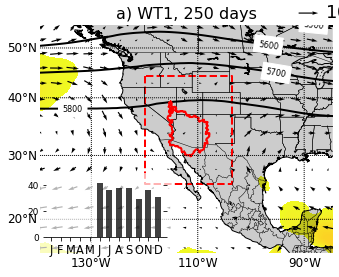

In [13]:
# Calculate the geometry of the plot dependent on how many panels there are
import math
PanWidth=4 # cm
PanHeight=2.5 # cm
xdist=0.5
ydist=0.5
Panels=rgrClustersFin[1].max()+1
iColums=np.min([4,Panels])
iRows=np.max([1,int((math.ceil(Panels/4.)))])
iXX=[0,1,2,3,0,1,2,3,0,1,2,3,0,1,2,3]
iYY=[0,0,0,0,1,1,1,1,2,2,2,2,3,3,3,3]

X_Fig=PanWidth*iColums+xdist*(iColums+1)
Y_Fig=PanHeight*iRows+(iRows+1)

plt.rcParams.update({'font.size': 18})
rgsLableABC=list(string.ascii_lowercase)
fig = plt.figure(figsize=(X_Fig,Y_Fig*1.5))
gs1 = gridspec.GridSpec(iRows,iColums)
gs1.update(left=0.05, right=0.95,
           bottom=0.47, top=0.94,
           wspace=0.05, hspace=0.20)
# rllcrnrlat,urcrnrlat,llcrnrlon,urcrnrlon=np.min(rgrLatPR_SR),np.max(rgrLatPR_SR),np.min(rgrLatPR_SR),np.max(rgrLatPR_SR)
dLat=((52-25)/2.)*1.5
dLon=(130-75)/2.
rllcrnrlat=np.mean((rgrLatWT_SR.min(),rgrLatWT_SR.max()))-dLat #      25 #rllcrnrlat-(urcrnrlat-rllcrnrlat)*0.03
urcrnrlat=np.mean((rgrLatWT_SR.min(),rgrLatWT_SR.max()))+dLat      #52 #urcrnrlat+(urcrnrlat-rllcrnrlat)*0.01
llcrnrlon=np.mean((rgrLonWT_SR.min(),rgrLonWT_SR.max()))-dLon #    -130 #llcrnrlon-abs(llcrnrlon-urcrnrlon)*0.01
urcrnrlon=np.mean((rgrLonWT_SR.min(),rgrLonWT_SR.max()))+dLon #     -75 #urcrnrlon+abs(llcrnrlon-urcrnrlon)*0.01
for pa in range(Panels):
    # define margins of subplot (see http://matplotlib.org/users/gridspec.html)
    iSampleSize=np.sum(rgrClustersFin[1] == pa)
    ax = plt.subplot(gs1[iYY[pa],iXX[pa]])
    try:
        m = Basemap(projection='cea',\
                    llcrnrlat= rllcrnrlat ,urcrnrlat=urcrnrlat,\
                    llcrnrlon=llcrnrlon,urcrnrlon=urcrnrlon,resolution='l', fix_aspect=False)
    except:
        stop()
    plt.axis('off')
    xi, yi = m(rgrLonWT_SR, rgrLatWT_SR)
    rgrColorTable=['#a50026','#d73027','#f46d43','#fdae61','#fee090','#ffffff','#e0f3f8','#abd9e9','#74add1','#4575b4','#313695'][::-1]

    # plot IVT
    biasContDist=100
    iContNr=len(rgrColorTable)+1
    clevs=np.linspace(300, 1600,200)
    rgrDataAct=rgrWTcentroids[rgiSorted[pa], :,:,rgsWTvarsA.index('IVT')]
    cs = m.contourf(xi,yi,rgrDataAct,clevs,cmap='plasma_r', extend='max', alpha=1, zlevel=20)
    # plot wind field
    iLev=1; iDist=4
    Q = plt.quiver(xi[::iDist, ::iDist],yi[::iDist, ::iDist],rgrWTcentroids[rgiSorted[pa],::iDist,::iDist,1],
                   rgrWTcentroids[rgiSorted[pa],::iDist,::iDist,2], units='width',zorder = 1, pivot='middle',width=0.004, scale=150)
    if pa == 0:
        qk = ax.quiverkey(Q, 0.95, 1.05, 10, r'$10 \frac{m}{s}$', labelpos='E') #,coordinates='figure')
    # plot geopotential height
    iContNr=20
    clevs=np.arange(0,10000,100)
    CS=m.contour(xi[:,:],yi[:,:],rgrWTcentroids[rgiSorted[pa],:,:,rgsWTvarsA.index('z')]/9.81,levels=clevs.astype('int'),
                 colors='k',linewidths=2, zlevel=0) #['#d9f0a3','#addd8e','#78c679','#41ab5d','#238443','#005a32'])
    clabels=plt.clabel(CS, inline=1, fontsize=8, fmt='%d')
    [txt.set_backgroundcolor('white') for txt in clabels]
    # plot cluster region
    iLatMax=rgrLatWT1D[rgiSrWT[0,:].max()]
    iLatMin=rgrLatWT1D[rgiSrWT[0,:].min()]
    iLonMax=rgrLonWT1D[rgiSrWT[1,:].max()]
    iLonMin=rgrLonWT1D[rgiSrWT[1,:].min()]
    lats = [iLatMin, iLatMax, iLatMax, iLatMin,iLatMin]
    lons = np.array([iLonMin, iLonMin, iLonMax, iLonMax, iLonMin])-360
    x, y = m(lons,lats)
    m.plot(x,y, lw=2, ls='--', c='r', zorder=1)

    # Lable the map
    plt.title(rgsLableABC[pa]+') WT'+str(pa+1)+', '+str(iSampleSize)+' days', fontsize=16)

    m.drawcoastlines(color='k')
    m.drawcountries(color='k')
    m.drawstates(color='k')
    m.fillcontinents(color='k',lake_color='white', alpha=0.2)
    # add shapefile of catchment
    XX,YY=m(ctr[:,0], ctr[:,1])
    m.plot(XX,YY, c='r', lw=2)
    
    if pa == 0:
        parallels = np.arange(0.,81,10.)
        # labels = [left,right,top,bottom]
        m.drawparallels(parallels,labels=[True,False,True,False], fontsize=12)
        meridians = np.arange(10.,351.,20.)
        m.drawmeridians(meridians,labels=[True,False,False,True], fontsize=12)

    # Add Histogram in the lower left corner
    rect = [0.02,0.07,0.4,0.25]
    from matplotlib.patches import Rectangle
    currentAxis = plt.gca()
    currentAxis.add_patch(Rectangle((0, 0), 0.45, 0.35, facecolor="white", transform = ax.transAxes, alpha=0.7,zorder = 100))
    
    ax1 = add_subplot_axes(ax,rect)
    # plt.axis('off')
    rgiMonths=np.array([rgiExtremeDays[rgrClustersFin[1] == pa][nn].month for nn in range(len(rgiExtremeDays[rgrClustersFin[1] == pa]))])
    ax1.hist(rgiMonths,np.array(range(1,14,1)), facecolor='k', alpha=0.75,rwidth=0.6)
    ax1.set_xticks(np.array(range(1,13,1))+0.5)
    ax1.set_xticklabels(['J','F','M','A','M','J','J','A','S','O','N','D'])
    ax1.spines['right'].set_visible(False)
    ax1.spines['left'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    ax1.xaxis.set_ticks_position('bottom')
    ax1.set_xlim([1,13])
    # ax2.yaxis.set_ticks_position('left')
    ax1.tick_params(
        axis='y',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        right='off',         # ticks along the top edge are off
        labelleft='off') # labels along the bottom edge are off
    ax1.patch.set_alpha(0.0)


    # ==========================================================================================
    # ==========================================================================================
    # plot the actual centroids for each WT
    LonWT=npzfile['LonWT']
    LatWT=npzfile['LatWT']
    pos1 = np.array(ax.get_position())
    gs2 = gridspec.GridSpec(1,len(rgsWTvars))
    gs2.update(left=pos1[0][0], right=pos1[1][0],
           bottom=0.10, top=0.30,
           wspace=0.05, hspace=0.20)
    for va in range(len(rgsWTvars)):
        ax = plt.subplot(gs2[0,va])
        CentroidsAct=rgrClustersFin[0][pa]
        CentroidsAct=np.reshape(CentroidsAct,(LonWT.shape[0],LonWT.shape[1],len(rgsWTvars)))
        m = Basemap(projection='cea',\
                    llcrnrlat= np.min(LatWT) ,urcrnrlat=np.max(LatWT),\
                    llcrnrlon=np.min(LonWT),urcrnrlon=np.max(LonWT),resolution='l', fix_aspect=False)
        xi, yi = m(LonWT, LatWT)
        cs1= plt.contourf(xi, yi, CentroidsAct[:,:,va], cmap='coolwarm',levels=np.linspace(-2,2,11),extend='both')
        plt.axis('off')
        # add shapefile of catchment
        XX,YY=m(ctr[:,0], ctr[:,1])
        m.plot(XX,YY, c='r', lw=2)
#         m.drawcoastlines(color='k')
        m.drawcountries(color='k')
        m.drawstates(color='k')
        plt.title(rgsLableABC[pa]+str(int(va+1))+') '+VarsFullName[va], fontsize=14)

# add colorbar for IVT
CbarAx = plt.axes([0.025, 0.38, 0.95, 0.02])
cb = plt.colorbar(cs, cax = CbarAx, orientation='horizontal', extend='max', ticks=np.arange(300,1600,200))
cb.ax.tick_params(labelsize=14)
cb.ax.set_title('Integrated vapor transport [kg m$^{-1}$ s$^{-1}$]', fontsize=14)

# add colorbar for centroids
CbarAx = plt.axes([0.025, 0.04, 0.95, 0.02])
cb = plt.colorbar(cs1, cax = CbarAx, orientation='horizontal', extend='both') #, ticks=np.arange(300,1600,200))
cb.ax.tick_params(labelsize=14)
cb.ax.set_title('normalized centroids []', fontsize=14)

# Save the plot
# plt.show()
sPlotFile=sPlotDir
# sPlotName= 'BottomUp-'+str(rgrClustersFin[1].max()+1)+'WT_Centroids.pdf'
sPlotName= 'BottomUp_'+str("%03d" % iNrOfExtremes)+'_Events_'+str(rgrClustersFin[1].max()+1)+'WT_Centroids_'+YYYY_stamp+'_'+VarsJoint+'_'+sMonths+'.png'
if os.path.isdir(sPlotFile) != 1:
    subprocess.call(["mkdir","-p",sPlotFile])
print( '        Plot map to: '+sPlotFile+sPlotName)
fig.savefig(sPlotFile+sPlotName)

### Plot and process precipitation centroids

In [ ]:
# # #############################################################################
# # ######             PLOT PRECIPITATION IN WTs
import matplotlib.gridspec as gridspec
from mpl_toolkits.basemap import Basemap, cm
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.gridspec as gridspec
from pylab import *
import string
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import shapefile

# start reading in the precipitation from PRISM for a larger region
iRegionPlus=100 # grid cell added around shape rectangle
ncid=Dataset('/glade/campaign/mmm/c3we/prein/observations/PRISM/data/PR/PRISM_daily_ppt_2014.nc', mode='r') # open the netcdf file
rgrLatPR=np.squeeze(ncid.variables['lat'][:])
rgrLonPR=np.squeeze(ncid.variables['lon'][:])
ncid.close()
rgrGridCells=[(rgrLonPR.ravel()[ii],rgrLatPR.ravel()[ii]) for ii in range(len(rgrLonPR.ravel()))]
rgrSRact=np.array(grPRregion.contains_points(rgrGridCells)); rgrSRact=np.reshape(rgrSRact, (rgrLatPR.shape[0], rgrLatPR.shape[1]))
rgiSrPR=np.array(np.where(rgrSRact == True))
iLatMax=np.min([rgiSrPR[0,:].max()+100, rgrLatPR.shape[0]-1])
iLatMin=np.max([rgiSrPR[0,:].min()-100, 0])
iLonMax=np.min([rgiSrPR[1,:].max()+100, rgrLatPR.shape[1]-1])
iLonMin=np.max([rgiSrPR[1,:].min()-100, 0])
rgrLatPR_SR=rgrLatPR[iLatMin:iLatMax,iLonMin:iLonMax]
rgrLonPR_SR=rgrLonPR[iLatMin:iLatMax,iLonMin:iLonMax]
rgrPRdata=np.zeros((rgrNrOfExtremes,iLatMax-iLatMin,iLonMax-iLonMin)); rgrPRdata[:]=np.nan
jj=0
for dd in range(len(rgiExtremeDays)):
    rgdTimeYY = pd.date_range(datetime.datetime(rgiExtremeDays[dd].year, 1, 1,0), end=datetime.datetime(rgiExtremeDays[dd].year, 12, 31,23), freq='d')
    rgiDD=np.where(((rgdTimeYY.year == rgiExtremeDays[dd].year) & (rgdTimeYY.month ==rgiExtremeDays[dd].month ) & (rgdTimeYY.day == rgiExtremeDays[dd].day)))[0]
    ncid=Dataset('/glade/campaign/mmm/c3we/prein/observations/PRISM/data/PR/PRISM_daily_ppt_'+str(rgiExtremeDays[dd].year)+'.nc', mode='r')
    try:
        rgrPRdata[dd,:,:]=np.squeeze(ncid.variables['PR'][rgiDD[0],iLatMin:iLatMax,iLonMin:iLonMax])
    except:
        stop()
    ncid.close()
    jj=jj+len(rgiDD)
rgrPRdata[rgrPRdata < 0]=np.nan

# precipitation in WTs
rgrPR_WTs=np.zeros((rgrClustersFin[1].max()+1,rgrPRdata.shape[1],rgrPRdata.shape[2])); rgrPR_WTs[:]=np.nan
for cc in range(rgrClustersFin[1].max()+1):
    rgiClAct=(rgrClustersFin[1] == (cc))
    try:
        rgrPR_WTs[cc,:]=np.nanmean(rgrPRdata[rgiClAct,:], axis=0)
    except:
        stop()



        Plot map to: /glade/u/home/prein/papers/Extreme-WTs-US/plots/WT-Centroids/PL-FLX_combination_hdbscan/18-WBDHU2/BottomUp_100_Events_4WT_precipitation_1981-2018_PSL-PW-MFL850_1-2-3-4-5-6-7-8-9-10-11-12.png


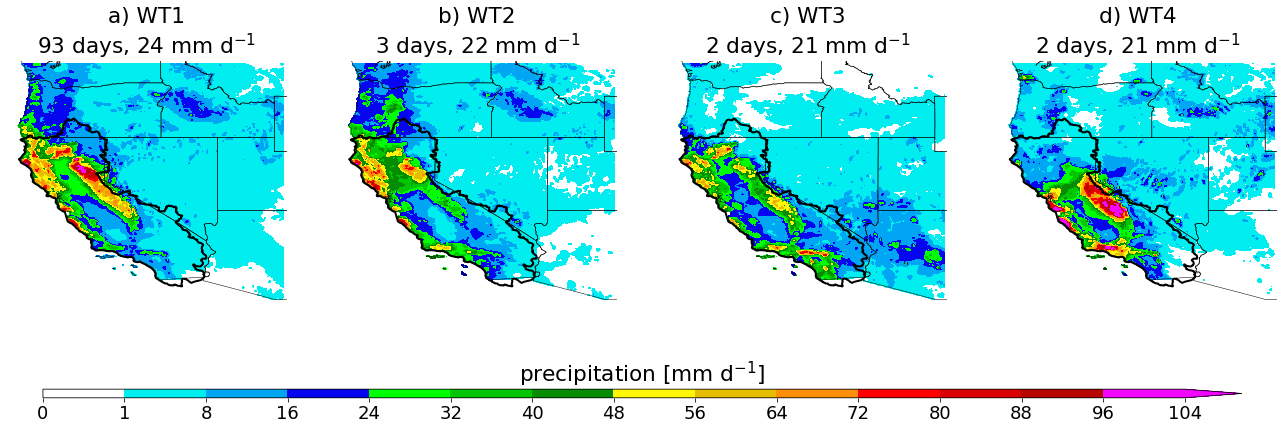

In [27]:
# Calculate the geometry of the plot dependent on how many panels there are
PanWidth=4 # cm
PanHeight=4 # cm
xdist=0.5
ydist=0.5
Panels=rgrClustersFin[1].max()+1
iColums=np.min([4,Panels])
iRows=np.max([1,int((math.ceil(Panels/4.)))])
iXX=[0,1,2,3,0,1,2,3,0,1,2,3,0,1,2,3]
iYY=[0,0,0,0,1,1,1,1,2,2,2,2,3,3,3,3]

X_Fig=PanWidth*iColums+xdist*(iColums+1)
Y_Fig=PanHeight*iRows+(iRows+1)

plt.rcParams.update({'font.size': 18})
rgsLableABC=list(string.ascii_lowercase)

fig = plt.figure(figsize=(X_Fig,Y_Fig))
gs1 = gridspec.GridSpec(iRows,iColums)
gs1.update(left=0.01, right=0.99,
           bottom=0.15, top=0.85,
           wspace=0.05, hspace=0.15)
rllcrnrlat,urcrnrlat,llcrnrlon,urcrnrlon=np.min(rgrLatPR_SR),np.max(rgrLatPR_SR),np.min(rgrLonPR_SR),np.max(rgrLonPR_SR)
rllcrnrlat=rllcrnrlat-(urcrnrlat-rllcrnrlat)*0.03
urcrnrlat=urcrnrlat+(urcrnrlat-rllcrnrlat)*0.01
llcrnrlon=llcrnrlon-abs(llcrnrlon-urcrnrlon)*0.01
urcrnrlon=urcrnrlon+abs(llcrnrlon-urcrnrlon)*0.01
for pa in range(Panels):
    # define margins of subplot (see http://matplotlib.org/users/gridspec.html)
    iSampleSize=np.sum(rgrClustersFin[1] == pa)
    ax = plt.subplot(gs1[iYY[pa],iXX[pa]])
    rAvPR=np.mean(rgrPRrecords[rgiExtremePR][rgrClustersFin[1] == (rgiSorted[pa])])
    m = Basemap(projection='cea',\
                    llcrnrlat= rllcrnrlat ,urcrnrlat=urcrnrlat,\
                    llcrnrlon=llcrnrlon,urcrnrlon=urcrnrlon,resolution='i', fix_aspect=True)
    plt.axis('off')
    xi, yi = m(rgrLonPR_SR, rgrLatPR_SR)
    #Load ColorMap
    rgrColorTable=['#00eeef','#00a5f3','#0505ef','#00ff00','#03c502','#058c02','#fff707','#e6bd01','#ff8f08','#ff0000','#d90104','#b70500','#f107fe']
    biasContDist=8
    iContNr=len(rgrColorTable)+1
    clevs=np.arange(0, iContNr*biasContDist,biasContDist)# ; clevs.astype('float')
    clevs=np.append([0],clevs); clevs[1]=1
    rgrColorTable=np.append(['#ffffff'],rgrColorTable)
    rgrDataAct=rgrPR_WTs[rgiSorted[pa], :,:]
    cs = m.contourf(xi,yi,rgrDataAct,clevs,colors=rgrColorTable, extend='max')
    # Lable the map
    plt.title(rgsLableABC[pa]+') WT'+str(pa+1)+'\n'+str(iSampleSize)+' days, '+str(int(rAvPR))+' mm d$^{-1}$') #, fontsize=16)

    # plot US States
    sUSStates='/glade/u/home/prein/ShapeFiles/US-States/cb_2013_us_state_5m'
    m.readshapefile(sUSStates, 'Temp_sf', drawbounds=True, linewidth=0.5, color='k')

    # add shapefile of catchment
    XX,YY=m(ctr[:,0], ctr[:,1])
    m.plot(XX,YY, c='k', lw=2)

# add colorbar
CbarAx = axes([0.05, 0.07, 0.90, 0.02])
cb = colorbar(cs, cax = CbarAx, orientation='horizontal', extend='both', ticks=clevs)
cb.ax.set_title('precipitation [mm d$^{-1}$]')


# Save the plot
# plt.show()
sPlotFile=sPlotDir
# sPlotName= 'BottomUp-'+str(rgrClustersFin[1].max()+1)+'WT_precipitation.pdf'
sPlotName= 'BottomUp_'+str("%03d" % iNrOfExtremes)+'_Events'+'_'+str(rgrClustersFin[1].max()+1)+'WT_precipitation'+'_'+YYYY_stamp+'_'+VarsJoint+'_'+sMonths+'.png'
if os.path.isdir(sPlotFile) != 1:
    subprocess.call(["mkdir","-p",sPlotFile])
print( '        Plot map to: '+sPlotFile+sPlotName)
fig.savefig(sPlotFile+sPlotName)
